In [3]:
import os
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"
import cv2
import numpy as np
from brisque import BRISQUE

### Utility functions

In [4]:
def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
        filename=im_path,
        flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
    
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
        gamma=2.2,
        intensity=0.0,
        light_adapt=0.0,
        color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result

def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
        gamma=2.2,
        scale=0.85,
        saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

### Dataset

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ToneMappingDataset(Dataset):
    def __init__(self, path: str, transform=None):
        self.path = path
        self.transform = transform
        
        self.files = [f for f in os.listdir(path) if f.endswith('.exr')]
        self.files.sort()
    
    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        base_filename = self.files[idx]
        
        file_path = os.path.join(self.path, base_filename)
        
        hdr_image = self._read_exr(file_path)
        
        low_exposure = np.clip(hdr_image * 0.2, 0, 1)  # Low exposure
        mid_exposure = np.clip(hdr_image * 0.5, 0, 1)  # Mid exposure
        high_exposure = np.clip(hdr_image * 1.5, 0, 1)  # High exposure
        
        

        if self.transform:
            # Convert numpy arrays to PIL images before applying transformations
            low_exposure = Image.fromarray((low_exposure * 255).astype(np.uint8))  # Convert to PIL image
            mid_exposure = Image.fromarray((mid_exposure * 255).astype(np.uint8))  # Convert to PIL image
            high_exposure = Image.fromarray((high_exposure * 255).astype(np.uint8))  # Convert to PIL image
            hdr_image = Image.fromarray((hdr_image * 255).astype(np.uint8))  # Convert to PIL image for target

            low_exposure = self.transform(low_exposure)
            mid_exposure = self.transform(mid_exposure)
            high_exposure = self.transform(high_exposure)
            hdr_image = self.transform(hdr_image)
        else:
            low_exposure = torch.tensor(low_exposure, dtype=torch.float32).permute(2, 0, 1)
            mid_exposure = torch.tensor(mid_exposure, dtype=torch.float32).permute(2, 0, 1)
            high_exposure = torch.tensor(high_exposure, dtype=torch.float32).permute(2, 0, 1)
            hdr_image = torch.tensor(hdr_image, dtype=torch.float32).permute(2, 0, 1)
        
        return low_exposure, mid_exposure, high_exposure, hdr_image
    
    def _read_exr(self, image_path: str) -> np.ndarray:
        return cv2.imread(
            filename=image_path,
            flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
        )

In [46]:
SIHDR_DATA_PATH = os.path.normpath("C:\\Users\\kacpe\\Code\\Uni\\25L\\SIGK\\data\\sihdr\\reconstructions\\maskhdr\\clip_95")

In [52]:
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),  # Ensure it is a tensor (you can add other transforms here if needed)
])

train_dataset = ToneMappingDataset(path=SIHDR_DATA_PATH, transform=resize_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
x_low, x_mid, x_high, x_hdr = next(iter(train_dataset))

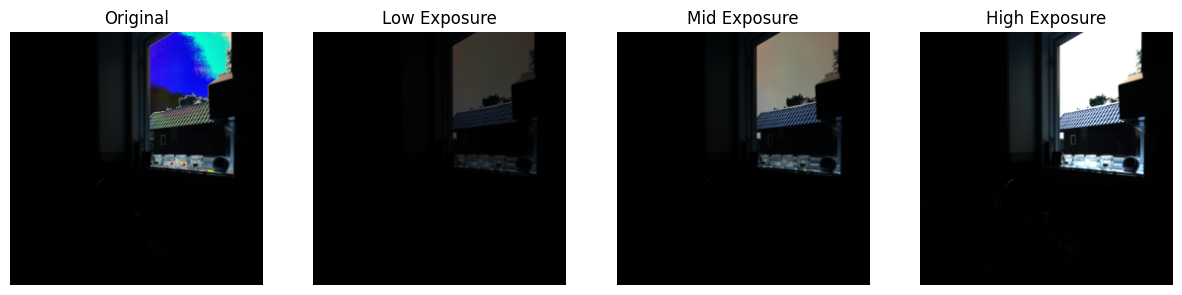

In [51]:
import matplotlib.pyplot as plt

def show_images(images: list, titles: list = None) -> None:
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()
show_images([x_hdr[0], x_low[0], x_mid[0], x_high[0]], titles=["Original", "Low Exposure", "Mid Exposure", "High Exposure"])

### Model architecture

In [57]:
import torch.nn as nn
import torchvision.models as models


class ToneMappingModel(nn.Module):
    def __init__(self):
        super(ToneMappingModel, self).__init__()

        # Load pre-trained ResNet-50 model from torchvision
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Use only the feature extraction part (remove the fully connected layers)
        self.encoder = nn.Sequential(*list(resnet50.children())[:-2])  # Remove the final classification layers

        # Decoder part (you can modify the layers here to refine the output image)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048 * 3, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in the range [0, 1] for LDR images
        )

    def forward(self, x_low, x_mid, x_high):
        features_low = self.encoder(x_low)
        features_mid = self.encoder(x_mid)
        features_high = self.encoder(x_high)

        # Fuse the features from the three exposures (concatenate along the channel dimension)
        fused_features = torch.cat([features_low, features_mid, features_high], dim=1)  # Concatenate along the channel dimension

        # Pass the fused features through the decoder
        output = self.decoder(fused_features)

        return output

In [68]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
model = ToneMappingModel().to(device)

In [61]:
x_low, x_mid, x_high, x_hdr = next(iter(train_dataset))
x_low, x_mid, x_high = x_low.unsqueeze(0).to(device), x_mid.unsqueeze(0).to(device), x_high.unsqueeze(0).to(device)  # Add batch dimension
output = model(x_low, x_mid, x_high)

### Loss

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import cv2
from torch import nn

vgg = models.vgg16(pretrained=True).features
vgg.eval()  # Set to evaluation mode (no gradient calculation)

# Apply Reinhard tone-mapping
def tone_map_reinhard(hdr_image: torch.Tensor) -> torch.Tensor:
    """
    Apply Reinhard tone mapping to HDR image.
    HDR image must be in the range [0, 1].
    """
    # Convert tensor to NumPy for OpenCV processing
    image_np = hdr_image.permute(1, 2, 0).cpu().numpy()
    
    # Apply Reinhard tone-mapping
    tonemap_operator = cv2.createTonemapReinhard(gamma=2.2, intensity=0.0, light_adapt=0.0, color_adapt=0.0)
    tone_mapped_image = tonemap_operator.process(image_np)
    
    # Convert back to tensor
    return torch.tensor(tone_mapped_image).permute(2, 0, 1).to(hdr_image.device)

def mu_law_compression(hdr_image: torch.Tensor, compression_factor: float = 255.0) -> torch.Tensor:
    """
    Apply adaptive µ-law compression to an HDR image.
    Args:
        hdr_image (torch.Tensor): HDR image tensor, expected in the range [0, 1].
        compression_factor (float): A factor that controls the amount of compression.
        
    Returns:
        torch.Tensor: The compressed image.
    """
    # Apply the µ-law compression formula
    compressed_image = torch.sign(hdr_image) * torch.log(1 + compression_factor * torch.abs(hdr_image)) / torch.log(1 + compression_factor)
    return compressed_image

# Feature contrast loss based on the VGG features
def feature_contrast_loss(hdr_image: torch.Tensor, ldr_image: torch.Tensor) -> torch.Tensor:
    """
    Compute the Feature Contrast Masking Loss between HDR and tone-mapped LDR images.
    The loss compares features from a pre-trained VGG model.
    """
    # Pass HDR and LDR images through the VGG network to get feature maps
    hdr_features = vgg(hdr_image)
    ldr_features = vgg(ldr_image)
    
    # Compute the contrast between the features
    hdr_contrast = torch.abs(hdr_features - hdr_features.mean(dim=[2,3], keepdim=True))  # Contrast for HDR
    ldr_contrast = torch.abs(ldr_features - ldr_features.mean(dim=[2,3], keepdim=True))  # Contrast for LDR
    
    # Normalize by the standard deviation across spatial dimensions
    hdr_contrast = hdr_contrast / (hdr_contrast.std(dim=[2,3], keepdim=True) + 1e-6)
    ldr_contrast = ldr_contrast / (ldr_contrast.std(dim=[2,3], keepdim=True) + 1e-6)
    
    # Compute the mean squared error between the HDR and LDR contrast maps
    contrast_loss = F.mse_loss(hdr_contrast, ldr_contrast)
    
    return contrast_loss

# Full loss function: combines contrast loss with an optional L1 loss (can add more components)
class ToneMappingLoss(nn.Module):
    def __init__(self, l1_weight=1.0, contrast_weight=1.0, compression_factor=255.0):
        super(ToneMappingLoss, self).__init__()
        self.l1_weight = l1_weight
        self.contrast_weight = contrast_weight
        self.compression_factor = compression_factor
    
    def forward(self, ldr_image: torch.Tensor, hdr_image: torch.Tensor) -> torch.Tensor:
        # Apply µ-law compression to HDR image
        compressed_hdr = mu_law_compression(hdr_image, self.compression_factor)
        
        # Compute L1 loss (optional component)
        l1_loss = F.l1_loss(ldr_image, compressed_hdr)
        
        # Compute feature contrast loss
        contrast_loss = feature_contrast_loss(compressed_hdr, ldr_image)
        
        # Combine the losses with respective weights
        total_loss = self.l1_weight * l1_loss + self.contrast_weight * contrast_loss
        return total_loss

c:\Users\kacpe\Code\Uni\25L\SIGK\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kacpe\Code\Uni\25L\SIGK\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
loss_fn = ToneMappingLoss(l1_weight=0.5, contrast_weight=1.0)

### Experiment Tracking Setup

In [ ]:
! pip install -q neptune

In [65]:
import neptune

In [67]:
NEPTUNE_PROJECT_NAME = "sigk/tone-mapping"
NEPTUNE_API_KEY = input()

### Training

In [ ]:
from tqdm import tqdm
import torch.optim as optim

In [ ]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: ToneMappingLoss,
    optimizer: optim.Adam,
    device: str,
    epochs: int = 5,
    run: neptune.Run | None = None,
) -> nn.Module:
    model.train()
    scaler = torch.amp.GradScaler()  # Enables mixed precision training

    for epoch in range(epochs):
        epoch_loss = 0

        for x_low, x_mid, x_high, x_hdr in tqdm(dataloader):
            x_low, x_mid, x_high, x_hdr = x_low.to(device), x_mid.to(device), x_high.to(device), x_hdr.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type=device_type):  # Automatically uses float16
                x_ldr = model(x_low, x_mid, x_high)
                loss = criterion(x_ldr, x_hdr)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        if run:
          run["train/epoch/loss"].append(epoch_loss)

    return model